In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import random

from sklearn import metrics
from collections import Counter
import argparse
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import re
from tqdm import tqdm
tqdm.pandas()
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

/home/RDC/zinovyee.hub/anaconda3/envs/dmc/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = pd.read_csv("dapps_with_features_v4.csv")
test = pd.read_csv("../data/source_codes_31163_contracts.csv")

In [3]:
data.category.value_counts(normalize=True)

games           0.262815
exchanges       0.224604
finance         0.159832
gambling        0.085275
other           0.070829
marketplaces    0.052656
high-risk       0.046132
social          0.034017
media           0.034017
development     0.029823
Name: category, dtype: float64

In [4]:
test.shape

(31163, 2)

In [5]:
# make sure in the test set we do not have our DApps SCs
test = test[~test['address'].isin(data['hash'])]

In [6]:
test.shape

(30340, 2)

In [7]:
def prep(row):
    if not pd.isnull(row):
        row = re.sub('\n', ' newline ', row)
        row = re.sub('\t', ' tab ', row)
        row = re.sub('\r', ' cr ', row)
        row = re.sub('/', '', row)
        row = re.sub('\*', '', row)
        row = re.sub(';', '', row)
        row = re.sub(' +', ' ', row)
    return row

test['SC_full'] = test.source_code.progress_apply(prep)
test = test.drop('source_code', axis=1)

100%|██████████| 30340/30340 [00:24<00:00, 1236.59it/s]


In [8]:
RS = 42

In [9]:
X       = data['SC_full']
y       = data.category

X_test  = test['SC_full']
classes = ['exchanges', 'finance', 'games', 'high-risk']
results = pd.DataFrame(np.zeros((len(X_test), 4)), columns=classes)

In [10]:
word_vectorizer   = TfidfVectorizer(
    sublinear_tf  = True,
    strip_accents = 'unicode',
    analyzer      = 'word',
    token_pattern = r'\w{1,}',
    #stop_words    = 'english',
    ngram_range   = (1, 1),
    max_features  = 40000) # max 144018

In [11]:
y_train = pd.DataFrame(np.zeros((len(y), 4)), columns=['exchanges', 'finance', 'games', 'high-risk'], dtype=int)

In [12]:
y_train.loc[y=='exchanges','exchanges']  = 1
y_train.loc[y=='finance', 'finance']     = 1
y_train.loc[y=='games', 'games']         = 1
y_train.loc[y=='high-risk', 'high-risk'] = 1

In [13]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
word_vectorizer.fit(X)
train_word_features  = word_vectorizer.transform(X)
test_word_features   = word_vectorizer.transform(X_test)

for i, cl in enumerate(classes):
    classifier = LogisticRegression(C=1, solver='sag', random_state=RS)
    classifier.fit(train_word_features, y_train.loc[:,cl])
    probs      = classifier.predict_proba(test_word_features)[:,1]  
    results[cl] = probs

In [14]:
cl = results.idxmax(axis=1)
m = results.max(axis=1)
res_df = pd.DataFrame({'val' : cl, 'max': m})

In [15]:
res_df.loc[((res_df['val']=='finance') & (res_df['max']<0.159)),'val'] = 'other'
res_df.loc[((res_df['val']=='games') & (res_df['max']<0.262)),'val'] = 'other'
res_df.loc[((res_df['val']=='high-risk') & (res_df['max']<0.046)),'val'] = 'other'
res_df.loc[((res_df['val']=='exchanges') & (res_df['max']<0.224)),'val'] = 'other'

In [16]:
res_df

,val,max
0,finance,0.308313
1,other,0.192962
2,other,0.192962
3,other,0.082678
4,other,0.246933
...,...,...
30335,other,0.255914
30336,high-risk,0.552431
30337,finance,0.194229
30338,other,0.204010


In [17]:
colors = res_df.val.map({'other': '#D3D5D2',
                 'games': '#258AD1',
                'high-risk': '#CA2C19',
                'exchanges': '#CF58EC',
                'finance': '#EA8F34'})

In [28]:
col_dic = {'other': '#D3D5D2',
         'games': '#258AD1',
        'high-risk': '#CA2C19',
        'exchanges': '#CF58EC',
        'finance': '#EA8F34'}

In [35]:
tsne = TSNE(n_components=3, metric='cosine', n_iter=1000, random_state=RS, n_jobs=10, verbose=1)
tsne.fit(train_word_features)
X_t = tsne.fit_transform(test_word_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2146 samples in 0.013s...
[t-SNE] Computed neighbors for 2146 samples in 0.504s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2146
[t-SNE] Computed conditional probabilities for sample 2000 / 2146
[t-SNE] Computed conditional probabilities for sample 2146 / 2146
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.049774
[t-SNE] KL divergence after 1000 iterations: 1.130184
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30340 samples in 0.045s...
[t-SNE] Computed neighbors for 30340 samples in 37.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30340
[t-SNE] Computed conditional probabilities for sample 2000 / 30340
[t-SNE] Computed conditional probabilities for sample 3000 / 30340
[t-SNE] Computed conditional probabilities for sample 4000 / 30340
[t-SNE] Computed conditional probabilities for sample 5000 / 30340
[t-SNE] Computed cond

In [43]:
colors.value_counts()

#D3D5D2    15915
#EA8F34     9773
#258AD1     3624
#CF58EC      703
#CA2C19      325
Name: val, dtype: int64

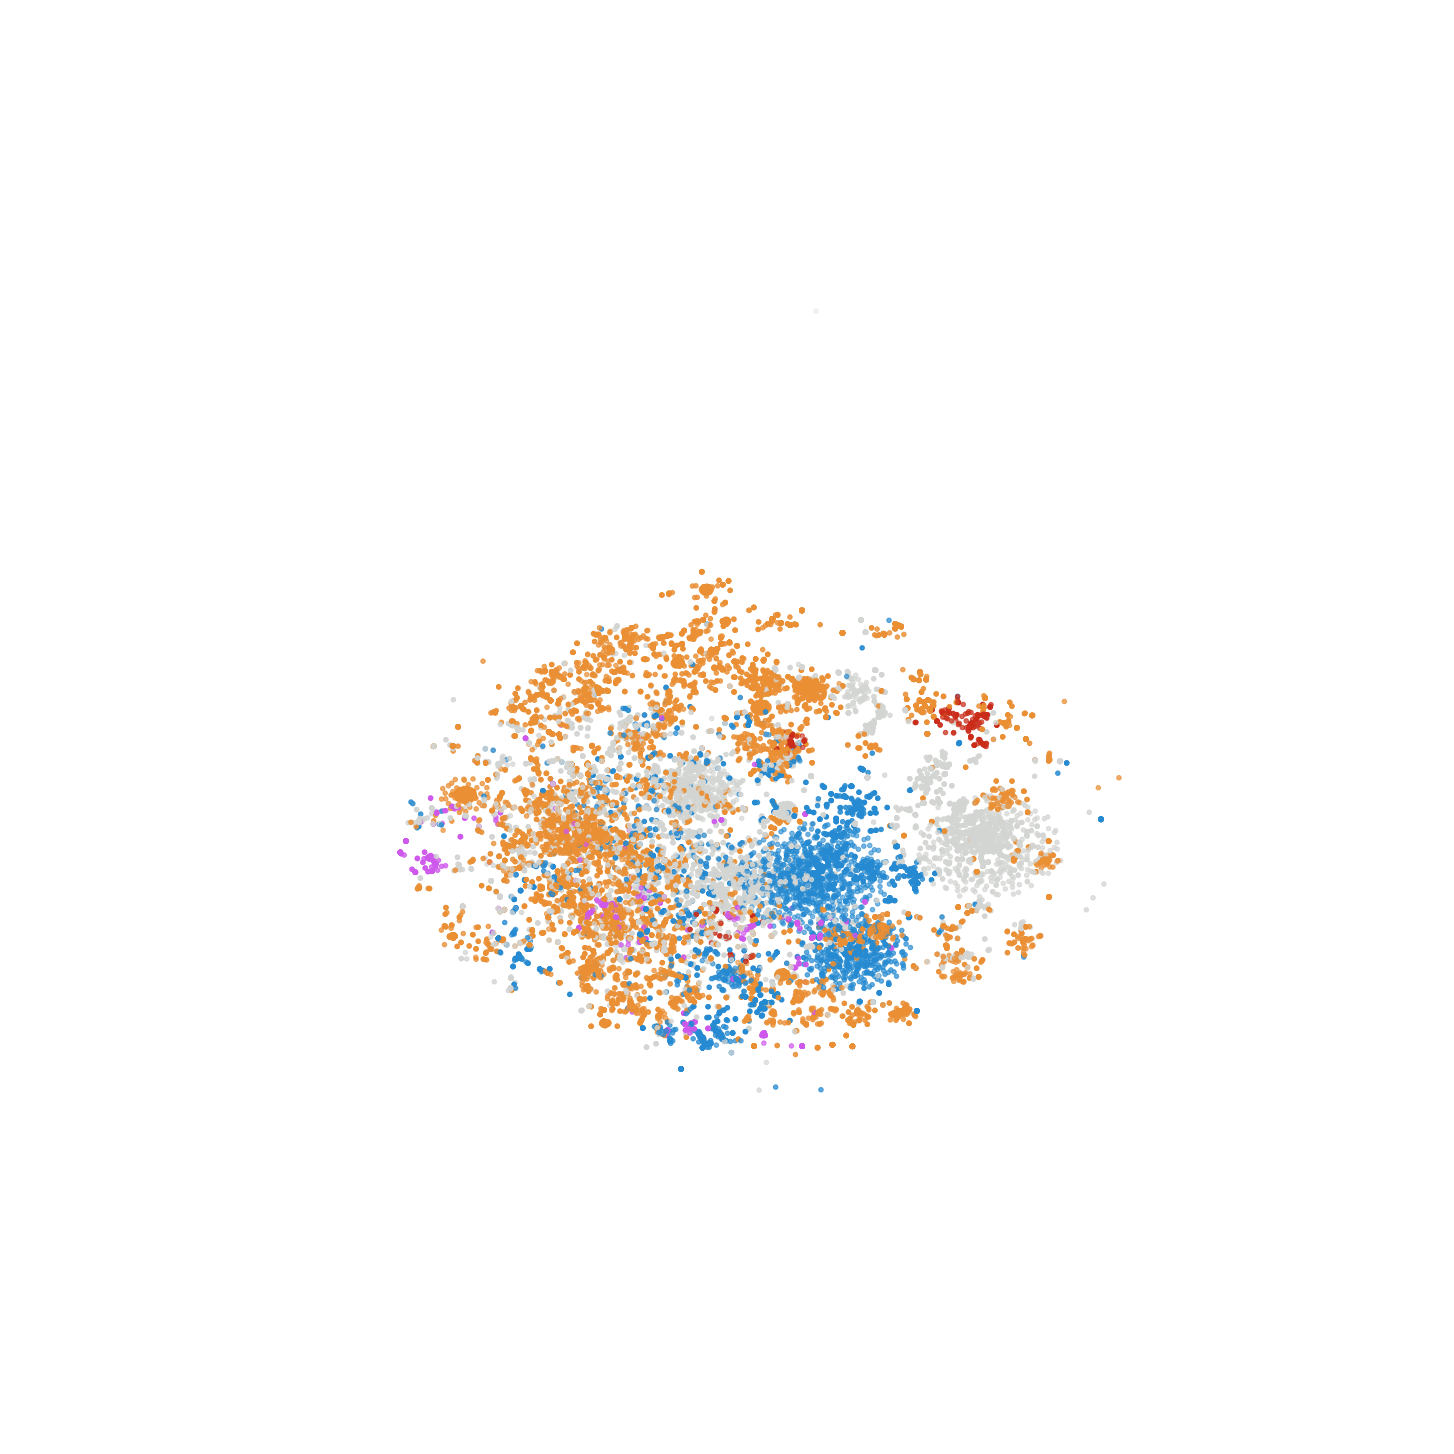

In [41]:
fig = plt.figure(1, figsize=(20, 20))
ax = Axes3D(fig)
ax.scatter(X_t[:,0], X_t[:,1], X_t[:,2], c=colors)
# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax._axis3don = False
for ii in range(0, 360, 5):
    ax.view_init(elev=10., azim=ii)
    plt.savefig(f"./plot/movie_{ii}.png", transparent=True, quality=100)